In [1]:
%load_ext autoreload
%autoreload 2
from  tm_common import *
IN_COLAB, output_dir = tm_get_working_config()
import tensorflow_hub as hub
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
import tensorflow_text
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Flatten,
    Embedding,
    Dense,
    Input,
    Embedding,
    GlobalAveragePooling1D,
)

c:\dev\topic_modelling\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\dev\topic_modelling\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\dev\topic_modelling\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword arg

In [30]:
# load train test sets
X_train, X_test, y_train, y_test    = tm_load_train_test_set(output_dir)
X_corpus_train, X_corpus_test       = tm_load_train_test_set(output_dir, option="raw_corpus")
# # only take a subset to fasten computation 
for i in range(2):
    X_corpus_train, y_train       = tm_get_subset(X_corpus_train, y_train)
    X_corpus_test, y_test       = tm_get_subset(X_corpus_test, y_test)

In [31]:
y_train_b, y_test_b = tm_multilabel_binarizer(y_train, y_test)

In [32]:
print( len(X_corpus_train) )
print( len(y_test_b)       )

1545
386


In [5]:
# Load BERT and the preprocessing model from TF Hub.
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1')
encoder = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3')

In [6]:
X_train_bert_preproc = preprocess(X_corpus_train)


In [7]:
X_train_bert_preproc.keys()

dict_keys(['input_type_ids', 'input_mask', 'input_word_ids'])

In [8]:
X_train_bert_emb = encoder(X_train_bert_preproc)['pooled_output']

In [9]:
del X_train_bert_preproc

In [33]:
X_test_bert_preproc = preprocess(X_corpus_test)
X_test_bert_emb = encoder(X_test_bert_preproc)['pooled_output']

In [11]:
del X_test_bert_preproc

In [47]:
bert_model = Sequential()
bert_model.add(Dense(256, activation='relu', input_dim=768))
bert_model.add(Dense(128, activation='relu'))
bert_model.add(Dense(30,activation='sigmoid'))
bert_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
bert_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 256)               196864    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 30)                3870      
                                                                 
Total params: 233,630
Trainable params: 233,630
Non-trainable params: 0
_________________________________________________________________


In [48]:
bert_model.fit(X_train_bert_emb, y_train_b, batch_size = 128, epochs=100)

Epoch 1/100
13/13 [==============================] - 0s 2ms/step - loss: 0.3775 - accuracy: 0.0673
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 0.2185 - accuracy: 0.1398
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 0.1989 - accuracy: 0.1534
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1951 - accuracy: 0.1728
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 0.1933 - accuracy: 0.1689
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1921 - accuracy: 0.1935
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1916 - accuracy: 0.1728
Epoch 8/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1915 - accuracy: 0.1663
Epoch 9/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1911 - accuracy: 0.1735
Epoch 10/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1902 - accuracy: 0.1903
Epoch 11/

4/4 [==============================] - 0s 2ms/step


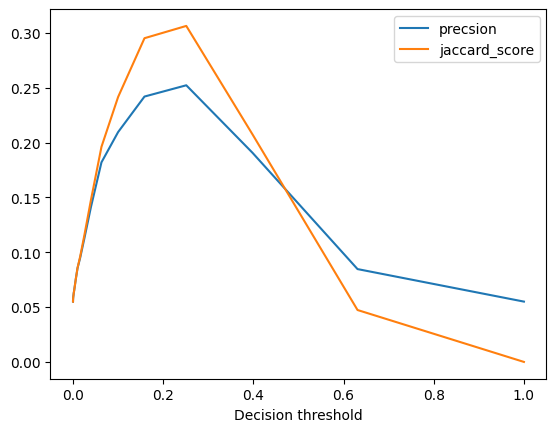

In [49]:
y_pred = bert_model.predict(X_train_bert_emb[:100])
threshold_test_use = tm_test_threshold(y_train_b[:100], y_pred)  
tm_plot_threshold_test(threshold_test_use)

In [50]:
max_config = threshold_test_use.query('precision == precision.max()')
t = max_config["threshold"]
best_t =  t.values[0]
best_t

0.25118864315094075

In [51]:
y_pred_bert = bert_model.predict(X_test_bert_emb)
y_pred_bert = (y_pred_bert > best_t).astype(np.float32)
precision_bert      = average_precision_score(y_test_b, y_pred_bert, average='micro')
jaccard_score_bert = jaccard_score(y_test_b, y_pred_bert, average='micro')


13/13 [==============================] - 0s 1ms/step


In [52]:
avg_precision_scores = [precision_bert]
jaccard_scores = [jaccard_score_bert]
result = pd.DataFrame(
    {
        'average_precision_scores' : avg_precision_scores,
        'jaccard_scores' : jaccard_scores
    }, index = ['BERT']
)
result.to_csv(f"{output_dir}result_supervised3.csv")

In [53]:
result1 = pd.read_csv(f"{output_dir}/supervised_1_results.csv")
result2 = pd.read_csv(f"{output_dir}/result_supervised2.csv")
result3 = pd.read_csv(f"{output_dir}/result_supervised3.csv")

In [54]:
supervised_restult = pd.concat([result1, result2,result3], axis=0)
supervised_restult.rename(columns={'Unnamed: 0' : 'model'})

,model,average_precision_scores,jaccard_scores
0,Dummy classifier,0.055033,0.000000
1,logistic : concatenation,0.139004,0.097722
2,SVM : concatenation,0.373852,0.382614
3,RandomForest,0.296040,0.345479
0,Word2Vec,0.084533,0.111220
1,USE,0.471676,0.508555
0,BERT,0.140975,0.188865
